# GROUP BY clause

**SYNTAX**:
```postgresql
SELECT 
    column_1, column_2, ...,
    aggregate_function(column_3)
FROM table_name
GROUP BY
   column_1,
   column_2,
   ...;
```

* The `GROUP BY` clause divides the rows returned from the `SELECT` statement into groups.
* For each group, you can apply an aggregate function such as `SUM()` to calculate the sum of items or `COUNT()` to get the number of items in the group.

PostgreSQL evaluates the `GROUP BY` clause after the `FROM` and `WHERE` clauses and before the `HAVING`, `SELECT`, `DISTINCT`, `ORDER BY` and `LIMIT` clauses.

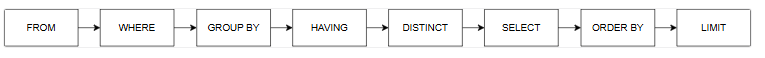

**`GROUP BY` with `SUM()` function**
```postgresql
SELECT
  customer_id,
  SUM (amount)
FROM payment
GROUP BY 
    customer_id
ORDER BY
  SUM (amount) DESC;
```

**`GROUP BY` clause with the `JOIN` clause**
```postgresql
SELECT
  first_name || ' ' || last_name full_name,
  SUM (amount) amount
FROM
  payment
  INNER JOIN customer USING (customer_id)
GROUP BY
  full_name
ORDER BY
  amount DESC;
```

**`GROUP BY` with multiple columns**
```postgresql
SELECT
  customer_id,
  staff_id,
  SUM(amount)
FROM
  payment
GROUP BY
  staff_id,
  customer_id
ORDER BY
  customer_id;
```

**`GROUP BY` clause with a date column**
```postgresql
SELECT
  payment_date::date payment_date,
  SUM(amount) sum
FROM
  payment
GROUP BY
  payment_date::date
ORDER BY
  payment_date DESC;
```

Since the values in the `payment_date` column are `timestamps`, we **cast them to `date`** values using the **cast operator `::`**.

**Output**:
````
payment_date |   sum
--------------+---------
 2007-05-14   |  514.18
 2007-04-30   | 5723.89
 2007-04-29   | 2717.60
 2007-04-28   | 2622.73
...
```

# HAVING clause

* The `HAVING` clause specifies a search condition for a group. 
* The `HAVING` clause is often used with the `GROUP BY` clause to filter groups based on a specified condition.
* Besides the `GROUP BY` clause, you can also include other clauses such as `JOIN` and `LIMIT` in the statement that uses the `HAVING` clause.

PostgreSQL evaluates the `HAVING` clause after the `FROM`, `WHERE`, `GROUP BY`, and before the `DISTINCT`, `SELECT`, `ORDER BY`, and `LIMIT` clauses.

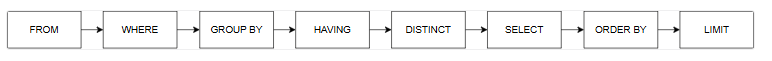

* Because PostgreSQL evaluates the `HAVING` clause before the `SELECT` clause, you cannot use the column aliases in the `HAVING` clause.
* This restriction arises from the fact that, at the point of `HAVING` clause evaluation, the column aliases specified in the `SELECT` clause are not yet available.

**`HAVING` vs. `WHERE`**
* The `WHERE` clause filters the rows based on a specified condition, whereas the `HAVING` clause filters groups of rows according to a specified condition.
* In other words, you apply the condition in the `WHERE` clause to the rows, while you apply the condition in the `HAVING` clause to the groups of rows.

**`HAVING` clause with `COUNT` example**
```postgresql
SELECT
  store_id,
  COUNT (customer_id)
FROM
  customer
GROUP BY
  store_id
HAVING
  COUNT (customer_id) > 300;
```

# GROUPING SETS

* Use the PostgreSQL `GROUPING SETS` to generate multiple grouping sets and combine the results (like `UNION ALL`).
* A **grouping set** is denoted by a comma-separated list of columns placed inside parentheses:
```
(column1, column2, ...)
```

**SYNTAX**:
```postgresql
SELECT
    c1,
    c2,
    aggregate_function(c3)
FROM
    table_name
GROUP BY
    GROUPING SETS (
        (c1, c2),
        (c1),
        (c2),
        ()
); 
```

* PostgreSQL provides the `GROUPING SETS` clause, which is a subclause of the `GROUP BY` clause.
* The `GROUPING SETS` allows you to define multiple grouping sets in the same query.
* In this syntax, we have four grouping sets `(c1,c2)`, `(c1)`, `(c2)`, and `()`.


You can use the `GROUPING SETS` clause instead of the `UNION ALL` clause like this:
```postgresql
SELECT
    brand,
    segment,
    SUM (quantity)
FROM
    sales
GROUP BY
    GROUPING SETS (
        (brand, segment),
        (brand),
        (segment),
        ()
    );
```

**Output**:

```
brand | segment | sum
-------+---------+-----
 null  | null    | 700
 XYZ   | Basic   | 300
 ABC   | Premium | 100
 ABC   | Basic   | 200
 XYZ   | Premium | 100
 ABC   | null    | 300
 XYZ   | null    | 400
 null  | Basic   | 500
 null  | Premium | 200
(9 rows)
```



# Grouping function

The `GROUPING()` function accepts an argument which can be a column name or an expression:
```postgresql
GROUPING( column_name | expression)
```

* The column_name or expression must match with the one specified in the `GROUP BY` clause.
* The `GROUPING()` function returns bit **0** if the argument is a member of the current grouping set and **1** otherwise.

```postgresql
SELECT
	GROUPING(brand) grouping_brand,
	GROUPING(segment) grouping_segment,
	brand,
	segment,
	SUM (quantity)
FROM
	sales
GROUP BY
	GROUPING SETS (
		(brand),
		(segment),
		()
	)
HAVING GROUPING(brand) = 0
ORDER BY
	brand,
	segment; 
```

# PostgreSQL CUBE

* PostgreSQL `CUBE` is a subclause of the `GROUP BY` clause.
* The `CUBE` allows you to generate multiple grouping sets.
* A grouping set is a set of columns to which you want to group.

**SYNTAX**
```postgresql
SELECT
    c1,
    c2,
    c3,
    aggregate (c4)
FROM
    table_name
GROUP BY
    CUBE (c1, c2, c3); 
```

It **generates all possible grouping sets** based on the dimension columns specified in `CUBE`.

The `CUBE` subclause is a short way to define multiple grouping sets, so the following are equivalent:
```postgresql
CUBE(c1,c2,c3)

GROUPING SETS (
    (c1,c2,c3),
    (c1,c2),
    (c1,c3),
    (c2,c3),
    (c1),
    (c2),
    (c3),
    ()
 )
```

In general, if the number of columns specified in the `CUBE` is **n**, then you will have **2^n** combinations.

PostgreSQL allows you to perform a **partial cube** to reduce the number of aggregates calculated.

```postgresql
SELECT
    c1,
    c2,
    c3,
    aggregate (c4)
FROM
    table_name
GROUP BY
    c1,
    CUBE (c1, c2); 
```

# PostgreSQL ROLLUP

**SYNTAX**
```postgresql
SELECT
    c1,
    c2,
    c3,
    aggregate(c4)
FROM
    table_name
GROUP BY
    ROLLUP (c1, c2, c3);
```

* The PostgreSQL `ROLLUP` is a subclause of the `GROUP BY` clause that offers a shorthand for defining multiple grouping sets.
* A grouping set is a set of columns by which you group.
* Different from the `CUBE` subclause, `ROLLUP` does not generate all possible grouping sets based on the specified columns. It just makes a subset of those.

For example, the `CUBE (c1,c2,c3)` makes all eight possible grouping sets:
```postgresql
(c1, c2, c3)
(c1, c2)
(c2, c3)
(c1,c3)
(c1)
(c2)
(c3)
()
```

However, the `ROLLUP(c1,c2,c3)` generates only four grouping sets, assuming the hierarchy `c1 > c2 > c3` as follows:
```postgresql
(c1, c2, c3)
(c1, c2)
(c1)
()
```

A common use of  `ROLLUP` is to calculate the aggregations of data by year, month, and date, considering the hierarchy `year > month > date`.

It is also possible to do a **partial roll-up** to reduce the number of subtotals generated.
```postgresql
SELECT
    c1,
    c2,
    c3,
    aggregate(c4)
FROM
    table_name
GROUP BY
    c1,
    ROLLUP (c2, c3); 
```

**EXAMPLE**
```postgresql
SELECT
    EXTRACT (YEAR FROM rental_date) y,
    EXTRACT (MONTH FROM rental_date) M,
    EXTRACT (DAY FROM rental_date) d,
    COUNT (rental_id)
FROM
    rental
GROUP BY
    ROLLUP (
        EXTRACT (YEAR FROM rental_date),
        EXTRACT (MONTH FROM rental_date),
        EXTRACT (DAY FROM rental_date)
    ); 
```